In [17]:
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
import warnings
from shapely import Point
import pandas as pd
from plane import Plane
from knn import AirportKNN
import utils
from data.data_worker import DataWorker
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Ignore deprecation warnings from Geopandas for the map use
warnings.simplefilter(action='ignore', category=FutureWarning)

In [19]:
worker = DataWorker("data/datasets_raw/airports.csv", "data/datasets_raw/runways.csv")

removal_cols_1 = ["continent", "iso_country", "iso_region", "municipality", "scheduled_service", "gps_code",
                  "iata_code", "local_code", "home_link", "wikipedia_link", "keywords"]

removal_cols_2 = ["id", "ident", "width_ft", "surface", "lighted", "closed", "le_ident", "le_latitude_deg", "le_longitude_deg",
                  "le_elevation_ft", "le_heading_degT", "le_displaced_threshold_ft", "he_ident", "he_latitude_deg",
                  "he_longitude_deg", "he_elevation_ft", "he_heading_degT", "he_displaced_threshold_ft"]

worker.clean_raws(removal_cols_1, removal_cols_2)
worker.merge()

print(f"\nNo. Workable Rows: {worker.merged_data.shape[0]}\n")

path = "data/datasets_merged/merged_data.pkl"
worker.merged_data.to_pickle(path)

VALIDATING...
ERROR: Missing data in DF. Killing rows containing missing data.

No. Workable Rows: 31704



In [60]:
test_set = pd.read_pickle('data/datasets_labeled/test_set.pkl')

In [50]:
# utils.generate_test_set(worker.merged_data, num_samples=5000, name="test_set_2")

0
1
2
3


KeyboardInterrupt: 

In [ ]:
# test_set_2 = pd.read_pickle('data/datasets_labeled/test_set.pkl')
# test_set = test_set_2

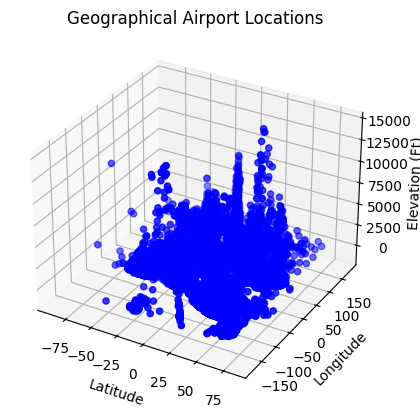

In [21]:
fig = plt.figure()
axis = fig.add_subplot(111, projection='3d')
axis.set_title('Geographical Airport Locations')
axis.set_xlabel("Latitude")
axis.set_ylabel("Longitude")
axis.set_zlabel("Elevation (Ft)")
x = worker.merged_data['latitude_deg']
y = worker.merged_data['longitude_deg']
z = worker.merged_data['elevation_ft']
axis.scatter(x, y, z, color='blue')
plt.show()

<Axes: >

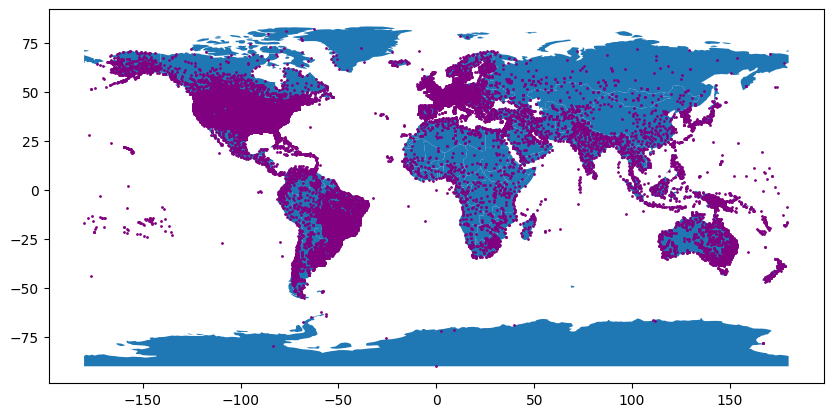

In [22]:
airports = []
for i in range(0, worker.merged_data.shape[0]):
    airports.append(Point((worker.merged_data.iloc[i]["longitude_deg"], worker.merged_data.iloc[i]["latitude_deg"])))
map = GeoDataFrame(worker.merged_data, geometry=airports)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
map.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='purple', markersize=1)

<Axes: >

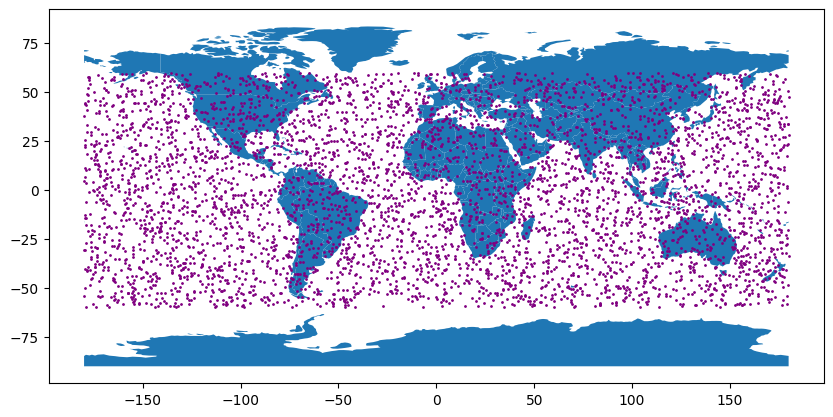

In [23]:
planes = []
for i in range(0, test_set.shape[0]):
    planes.append(Point((test_set.iloc[i]["longitude_deg"], test_set.iloc[i]["latitude_deg"])))
map = GeoDataFrame(test_set, geometry=planes)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
map.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='purple', markersize=1)

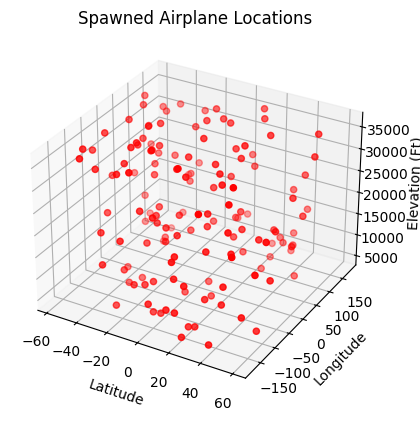

In [24]:
percent = .03
percent_samples = int(percent * test_set.shape[0])

fig = plt.figure()

axis = fig.add_subplot(111, projection='3d')
axis.set_title('Spawned Airplane Locations')
axis.set_xlabel("Latitude")
axis.set_ylabel("Longitude")
axis.set_zlabel("Elevation (Ft)")
x = test_set['latitude_deg'][:percent_samples]
y = test_set['longitude_deg'][:percent_samples]
z = test_set['elevation_ft'][:percent_samples]
axis.scatter(x, y, z, color='red')

plt.show()

In [64]:
knn = AirportKNN(airports=worker.merged_data.copy(), test_set=test_set)
knn.prepare_data()
knn.train()
knn.evaluate()


In [77]:
old_flight_range_deltas = []
old_dist_from_port_pred = []
old_dist_from_port_act = []
old_runway_deltas = []
old_elevation_deltas = []

for i, pred in enumerate(knn.predicted):
    actual = test_set.iloc[i]["airport_ref"]
    pred_lat = worker.merged_data.loc[worker.merged_data["airport_ref"] == pred]["latitude_deg"].values[0]
    pred_long = worker.merged_data.loc[worker.merged_data["airport_ref"] == pred]["longitude_deg"].values[0]
    act_lat = worker.merged_data.loc[worker.merged_data["airport_ref"] == actual]["latitude_deg"].values[0]
    act_long = worker.merged_data.loc[worker.merged_data["airport_ref"] == actual]["longitude_deg"].values[0]

    betwixt_airport_distance = utils.estimate_distance((pred_lat, pred_long), (act_lat, act_long))

    plane_lat = test_set.iloc[i]["latitude_deg"]
    plane_long = test_set.iloc[i]["longitude_deg"]
    plane_elev = test_set.iloc[i]["elevation_ft"]
    plane_runway = test_set.iloc[i]["length_ft"]
    plane_to_pred = utils.estimate_distance((pred_lat, pred_long), (plane_lat, plane_long))
    plane_to_act = utils.estimate_distance((act_lat, act_long), (plane_lat, plane_long))

    flight_range_delta = plane_to_act - plane_to_pred

    old_flight_range_deltas.append(flight_range_delta / 5280)

    pred_runway = max(worker.merged_data.loc[worker.merged_data["airport_ref"] == pred]["length_ft"].values)
    act_runway = max(worker.merged_data.loc[worker.merged_data["airport_ref"] == actual]["length_ft"].values)

    pred_elevation = worker.merged_data.loc[worker.merged_data["airport_ref"] == pred]["elevation_ft"].values[0]
    act_elevation = worker.merged_data.loc[worker.merged_data["airport_ref"] == actual]["elevation_ft"].values[0]

    plane_lat = test_set.iloc[i]["latitude_deg"]
    plane_long = test_set.iloc[i]["longitude_deg"]

    plane_to_pred = utils.estimate_distance((pred_lat, pred_long), (plane_lat, plane_long)) / 5280
    plane_to_act = utils.estimate_distance((act_lat, act_long), (plane_lat, plane_long)) / 5280

    old_dist_from_port_pred.append(plane_to_pred)
    old_dist_from_port_act.append(plane_to_act)

    old_flight_range_deltas.append(plane_to_act - plane_to_pred)

    old_runway_deltas.append(act_runway - pred_runway)

    old_elevation_deltas.append((plane_elev - act_elevation) - (plane_elev - pred_elevation))


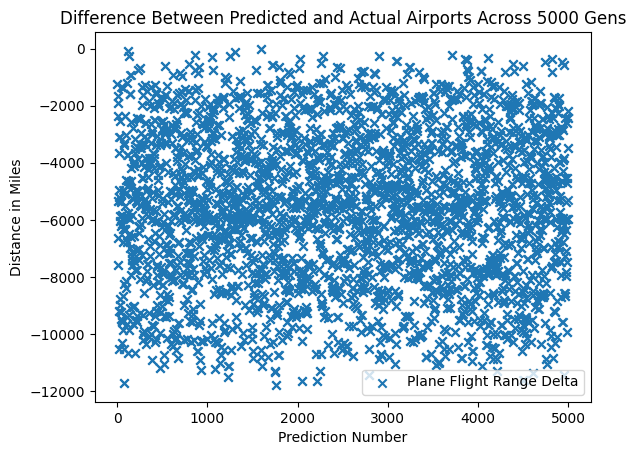

In [78]:
fig, ax = plt.subplots()
x = range(1, 5000)
ax.scatter(x, old_flight_range_deltas[:4999], label='Plane Flight Range Delta', marker='x')
plt.xlabel('Prediction Number')
plt.ylabel('Distance in Miles')
plt.title('Difference Between Predicted and Actual Airports Across 5000 Gens')
plt.legend()

plt.show()

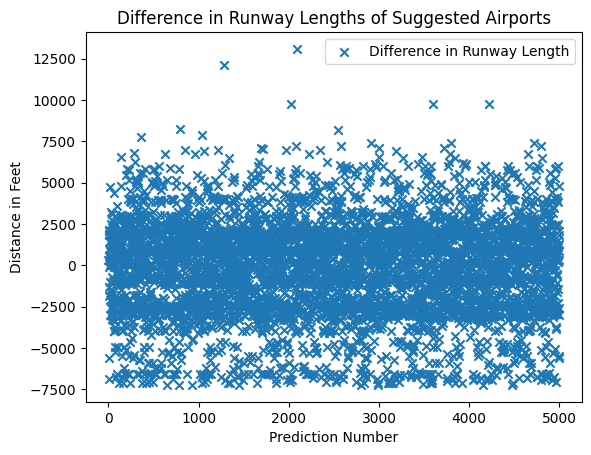

In [82]:
fig, ax = plt.subplots()
x = range(1, 5000)
ax.scatter(x, old_runway_deltas[:4999], label="Difference in Runway Length", marker='x')
plt.xlabel('Prediction Number')
plt.ylabel('Distance in Feet')
plt.title('Difference in Runway Lengths of Suggested Airports')
plt.legend()

plt.show()

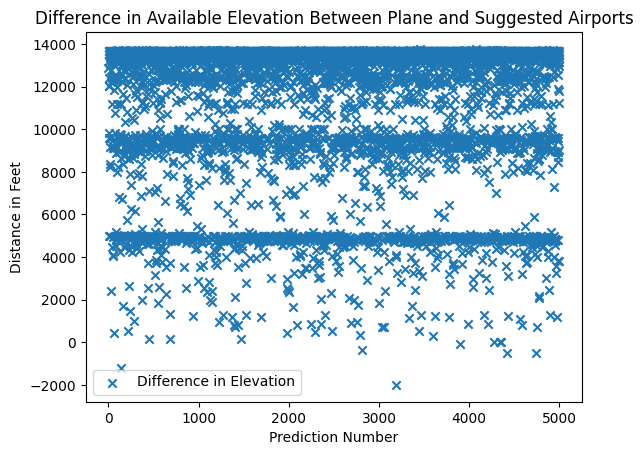

In [83]:
plt.show()
fig, ax = plt.subplots()
x = range(1, 5000)
ax.scatter(x, old_elevation_deltas[:4999], label="Difference in Elevation", marker='x')
plt.xlabel('Prediction Number')
plt.ylabel('Distance in Feet')
plt.title('Difference in Available Elevation Between Plane and Suggested Airports')
plt.legend()

plt.show()

Below we will try to carry out cross validation to see what values of k we should be setting for neighbors. This is important to ensure that we have optimized what value of k works best for us.


In [27]:
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = AirportKNN(airports=worker.merged_data, test_set=test_set, num_neighbors=k)
    print("Accuracy: \n")
    knn.fit()
    print("k value: ")
    print(k)
    print("cross_validate score: ")
    scores.append(knn.cross_validate())
    print("\n")


scores = np.array(scores)
best_k = np.argmax(scores) + 1

print("Best k:")
print(best_k)

Accuracy: 

k value: 
1
cross_validate score: 
0.05028391167192429


Accuracy: 

k value: 
2
cross_validate score: 
0.03132492113564669


Accuracy: 

k value: 
3
cross_validate score: 
0.024227129337539434


Accuracy: 

k value: 
4
cross_validate score: 
0.019558359621451103


Accuracy: 

k value: 
5
cross_validate score: 
0.018233438485804415


Accuracy: 

k value: 
6
cross_validate score: 
0.01523659305993691


Accuracy: 

k value: 
7
cross_validate score: 
0.014921135646687697


Accuracy: 

k value: 
8
cross_validate score: 
0.013722397476340692


Accuracy: 

k value: 
9
cross_validate score: 
0.012145110410094636


Accuracy: 

k value: 
10
cross_validate score: 
0.011766561514195584


Accuracy: 

k value: 
11
cross_validate score: 
0.010788643533123029


Accuracy: 

k value: 
12
cross_validate score: 
0.010410094637223973


Accuracy: 

k value: 
13
cross_validate score: 
0.010599369085173501


Accuracy: 

k value: 
14
cross_validate score: 
0.009905362776025236


Accuracy: 

k valu

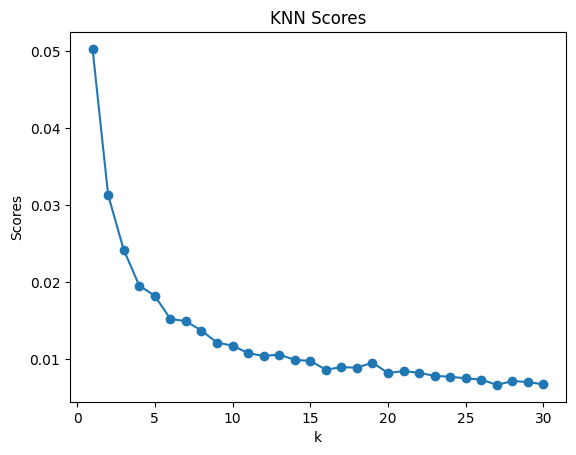

In [28]:
plt.plot(k_values, scores, marker='o')
plt.title('KNN Scores')
plt.xlabel('k')
plt.ylabel('Scores')
plt.show()

In [41]:
flight_range_deltas = []
dist_from_port_pred = []
dist_from_port_act = []
runway_deltas = []
elevation_deltas = []

for i in range(0, test_set.shape[0]):
    test_plane = Plane(test_set.iloc[i]["latitude_deg"], test_set.iloc[i]["longitude_deg"], test_set.iloc[i]["elevation_ft"], test_set.iloc[i]["length_ft"], test_set.iloc[i]["latitude_deg"])
    
    knn = AirportKNN(airports=worker.merged_data.copy(), test_set=test_set.iloc[i].to_frame().T)
    knn.prepare_data(proto_min=True, tar_plane=test_plane)
    knn.train()
    knn.evaluate()
    
    actual = test_set.iloc[i]["airport_ref"]
    pred_lat = worker.merged_data.loc[worker.merged_data["airport_ref"] == knn.predicted[0]]["latitude_deg"].values[0]
    pred_long = worker.merged_data.loc[worker.merged_data["airport_ref"] == knn.predicted[0]]["longitude_deg"].values[0]
    act_lat = worker.merged_data.loc[worker.merged_data["airport_ref"] == actual]["latitude_deg"].values[0]
    act_long = worker.merged_data.loc[worker.merged_data["airport_ref"] == actual]["longitude_deg"].values[0]

    pred_runway = max(worker.merged_data.loc[worker.merged_data["airport_ref"] == knn.predicted[0]]["length_ft"].values)
    act_runway = max(worker.merged_data.loc[worker.merged_data["airport_ref"] == actual]["length_ft"].values)

    pred_elevation = worker.merged_data.loc[worker.merged_data["airport_ref"] == knn.predicted[0]]["elevation_ft"].values[0]
    act_elevation = worker.merged_data.loc[worker.merged_data["airport_ref"] == actual]["elevation_ft"].values[0]
    
    plane_lat = test_set.iloc[i]["latitude_deg"]
    plane_long = test_set.iloc[i]["longitude_deg"]
    
    plane_to_pred = utils.estimate_distance((pred_lat, pred_long), (plane_lat, plane_long)) / 5280
    plane_to_act = utils.estimate_distance((act_lat, act_long), (plane_lat, plane_long)) / 5280
    
    dist_from_port_pred.append(plane_to_pred)
    dist_from_port_act.append(plane_to_act)

    flight_range_deltas.append(plane_to_act - plane_to_pred)

    runway_deltas.append(act_runway - pred_runway)

    # print(pred_runway)
    # print(act_runway)
    # print("////////")
    # print(pred_elevation)
    # print(act_elevation)
    # print("??????")

    # print(knn.predicted[0])
    # print(worker.merged_data.loc[worker.merged_data["airport_ref"] == knn.predicted[0]]["elevation_ft"].values[0])
    # print(actual)
    # print(worker.merged_data.loc[worker.merged_data["airport_ref"] == actual]["elevation_ft"].values[0])

    elevation_deltas.append((test_plane.elevation - act_elevation) - (test_plane.elevation - pred_elevation))
    
    # print(flight_range_deltas)
    # print(betwixt_airport_distance / 5280)
    # print(utils.estimate_distance((pred_lat, pred_long), (test_plane.latitude, test_plane.longitude)) / 5280)
    # print(utils.estimate_distance((act_lat, act_long), (test_plane.latitude, test_plane.longitude)) / 5280)

In [42]:
# fig, ax = plt.subplots()
# x = range(1, 5000)
# ax.plot(x, flight_range_deltas[:5000], label='Plane Flight Range Delta', marker='x')
# plt.xlabel('Prediction Number')
# plt.ylabel('Distance in Miles')
# plt.title('Comparison of Distances for Across 5000 Generations')
# plt.legend()
#
# plt.show()

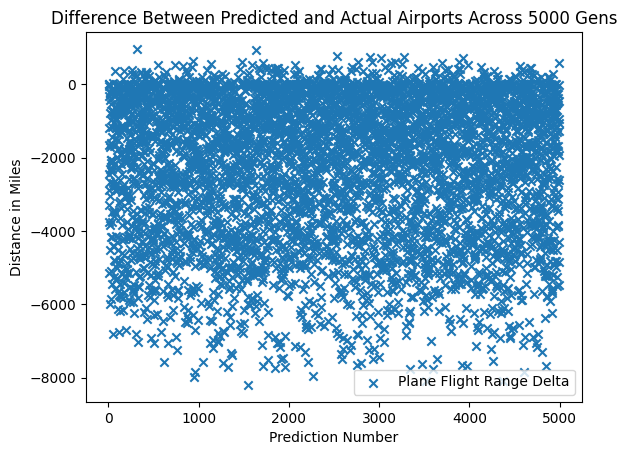

In [79]:
fig, ax = plt.subplots()
x = range(1, 5000)
ax.scatter(x, flight_range_deltas[:4999], label='Plane Flight Range Delta', marker='x')
plt.xlabel('Prediction Number')
plt.ylabel('Distance in Miles')
plt.title('Difference Between Predicted and Actual Airports Across 5000 Gens')
plt.legend()

plt.show()

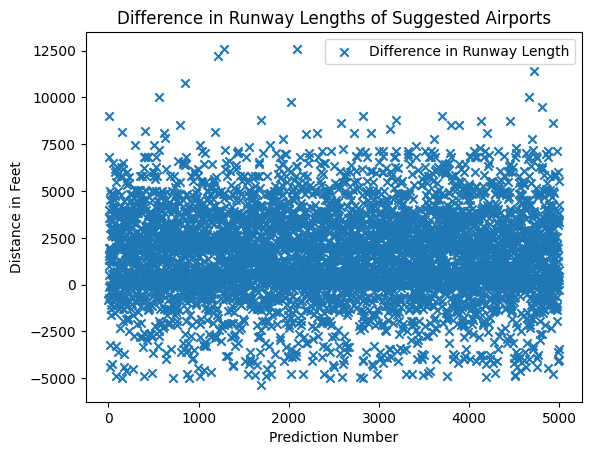

In [84]:
fig, ax = plt.subplots()
x = range(1, 5000)
ax.scatter(x, runway_deltas[:4999], label="Difference in Runway Length", marker='x')
plt.xlabel('Prediction Number')
plt.ylabel('Distance in Feet')
plt.title('Difference in Runway Lengths of Suggested Airports')
plt.legend()

plt.show()

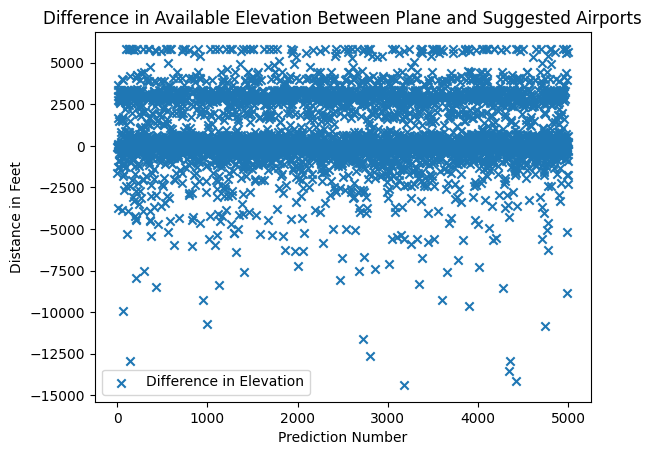

In [85]:
plt.show()
fig, ax = plt.subplots()
x = range(1, 5000)
ax.scatter(x, elevation_deltas[:4999], label="Difference in Elevation", marker='x')
plt.xlabel('Prediction Number')
plt.ylabel('Distance in Feet')
plt.title('Difference in Available Elevation Between Plane and Suggested Airports')
plt.legend()

plt.show()

In [87]:
old_flight_range_deltas_mean = np.mean(old_flight_range_deltas)
old_runway_deltas_mean = np.mean(old_runway_deltas)
old_elevation_deltas_mean = np.mean(old_elevation_deltas)

flight_range_deltas_mean = np.mean(flight_range_deltas)
runway_deltas_mean = np.mean(runway_deltas)
elevation_deltas_mean = np.mean(elevation_deltas)

print(f"Mean Difference in Flight Range: Old - {old_flight_range_deltas_mean} vs. New - {flight_range_deltas_mean}")
print(f"Mean Difference in Runway Length: Old - {old_runway_deltas_mean} vs. New - {runway_deltas_mean}")
print(f"Mean Difference in Elevation: Old - {old_elevation_deltas_mean} vs. New - {elevation_deltas_mean}")

Mean Difference in Flight Range: Old - -5553.580455766457 vs. New - -2241.239261425482
Mean Difference in Runway Length: Old - -226.9864 vs. New - 1570.4908
Mean Difference in Elevation: Old - 11107.3418 vs. New - 667.3334
